Synthesis sound

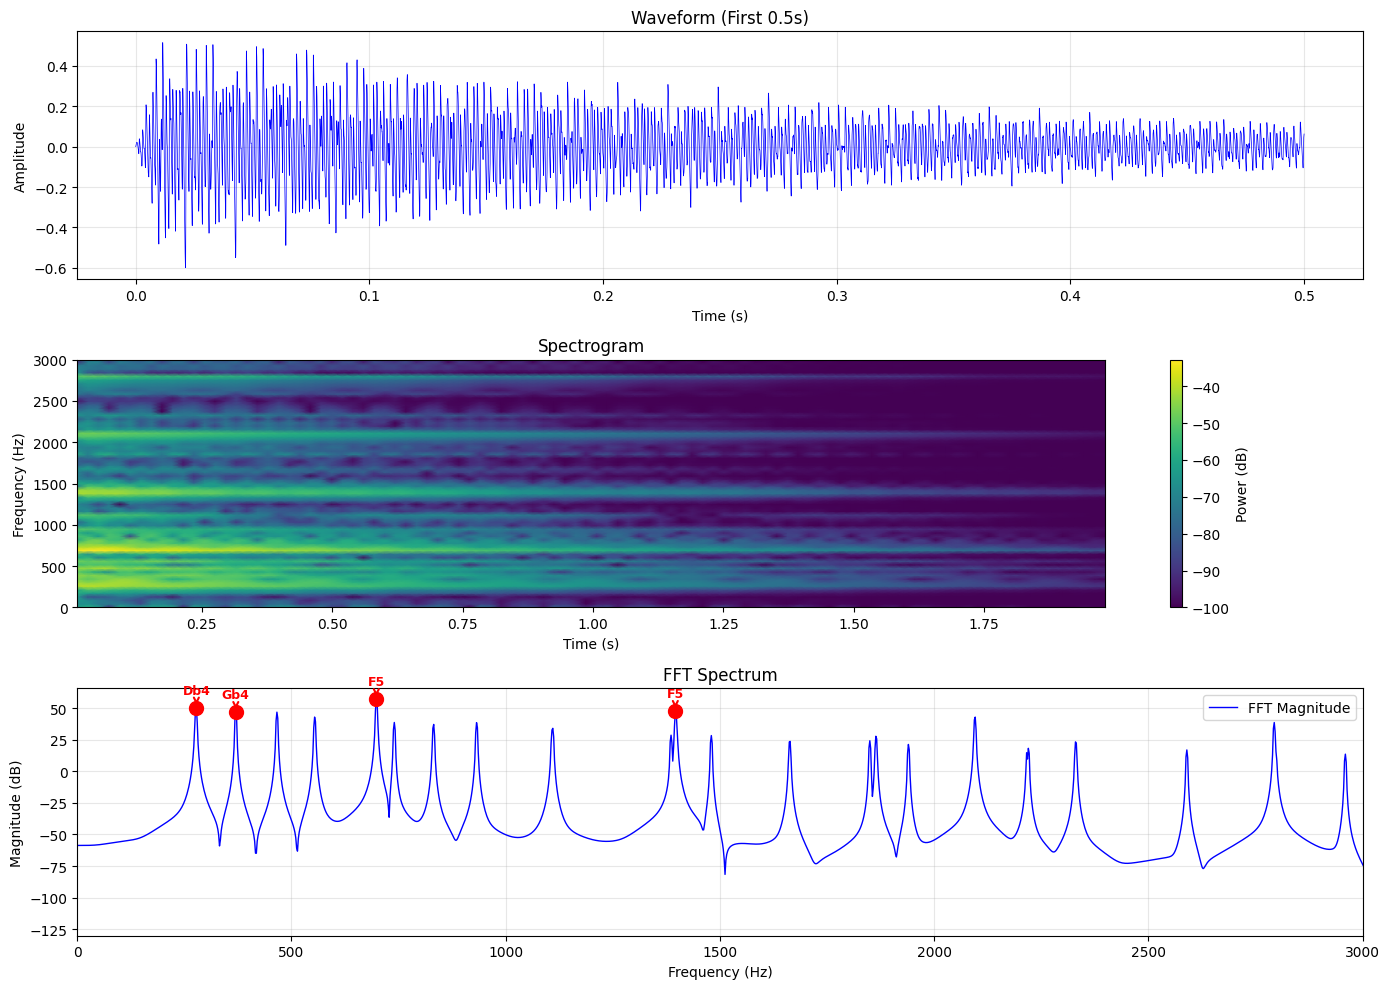

In [4]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal as sp_signal

class PianoSynthesizer:
    def __init__(self, sample_rate=44100, master_amp=0.6):
        self.sample_rate = sample_rate
        self.master_amp = master_amp
        self.frequencies = [698.46, 466.16, 369.99, 277.18]
        self.note_names = ["F5", "Bb4", "Gb4", "Db4"]
        self.note_amps = [1.0, 0.3, 0.3, 0.5]
        self.signal = None
    
    def piano_envelope(self, t, attack=0.01, decay=3.5):
        env = np.zeros_like(t)
        a = int(attack * self.sample_rate)
        env[:a] = np.linspace(0, 1, a)
        env[a:] = np.exp(-3 * (t[a:] - attack))
        return env
    
    def synthesize(self, duration=4.0):
        t = np.arange(0, duration, 1 / self.sample_rate)
        self.signal = np.zeros_like(t)
        
        for f, note_amp in zip(self.frequencies, self.note_amps):
            note = np.zeros_like(t)
            
            # Harmonics (piano-like)
            for h in range(1, 9):
                harmonic_amp = (1 / h) * np.exp(-0.25 * h)
                note += harmonic_amp * np.sin(2 * np.pi * f * h * t)
            
            note *= self.piano_envelope(t)
            self.signal += note_amp * note
        
        # Normalize & scale
        self.signal /= np.max(np.abs(self.signal))
        self.signal *= self.master_amp
        return self.signal
    
    def play(self):
        if self.signal is None:
            raise ValueError("Signal not synthesized. Call synthesize() first.")
        sd.play(self.signal, self.sample_rate)
        sd.wait()
    
    def plot_spectrum(self, fft_duration=0.5):
        if self.signal is None:
            raise ValueError("Signal not synthesized. Call synthesize() first.")
        
        N = int(self.sample_rate * fft_duration)
        fft_signal = self.signal[:N]
        window = np.hanning(N)
        fft_signal *= window
        
        fft_result = np.fft.rfft(fft_signal)
        fft_mag = np.abs(fft_result)
        fft_freqs = np.fft.rfftfreq(N, 1 / self.sample_rate)
        
        # Convert to dB
        fft_db = 20 * np.log10(fft_mag + 1e-12)
        
        # Find peaks in the spectrum
        peaks, _ = find_peaks(fft_db, height=0, distance=20)
        peak_freqs = fft_freqs[peaks]
        peak_mags = fft_db[peaks]
        
        # Sort by magnitude and get top peaks
        top_peaks_idx = np.argsort(peak_mags)[-len(self.frequencies):]
        top_peaks_freqs = peak_freqs[top_peaks_idx]
        top_peaks_mags = peak_mags[top_peaks_idx]
        
        plt.figure(figsize=(14, 5))
        plt.plot(fft_freqs, fft_db, label="FFT Magnitude")
        
        # Annotate peaks with note names
        for freq, mag in zip(top_peaks_freqs, top_peaks_mags):
            closest_idx = np.argmin(np.abs(np.array(self.frequencies) - freq))
            note_name = self.note_names[closest_idx]
            plt.annotate(note_name, xy=(freq, mag), xytext=(0, 10), 
                        textcoords="offset points", ha="center", fontsize=10, 
                        fontweight="bold", color="red",
                        arrowprops=dict(arrowstyle="->", color="red", lw=1.5))
        
        plt.xlim(0, 3000)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude (dB)")
        plt.title("FFT Spectrum – Piano-Like Chord")
        plt.grid(True)
        plt.show()
    
    def plot_realtime_visualization(self, fft_duration=0.5):
        """Plot waveform, spectrogram, and FFT spectrum together"""
        if self.signal is None:
            raise ValueError("Signal not synthesized. Call synthesize() first.")
        
        N = int(self.sample_rate * fft_duration)
        fft_signal = self.signal[:N]
        window = np.hanning(N)
        fft_signal_windowed = fft_signal * window
        
        # FFT analysis
        fft_result = np.fft.rfft(fft_signal_windowed)
        fft_mag = np.abs(fft_result)
        fft_freqs = np.fft.rfftfreq(N, 1 / self.sample_rate)
        fft_db = 20 * np.log10(fft_mag + 1e-12)
        
        # Create figure with 3 subplots
        fig, axes = plt.subplots(3, 1, figsize=(14, 10))
        
        # 1. Waveform
        time_axis = np.arange(len(fft_signal)) / self.sample_rate
        axes[0].plot(time_axis, fft_signal, linewidth=0.5, color='blue')
        axes[0].set_xlabel("Time (s)")
        axes[0].set_ylabel("Amplitude")
        axes[0].set_title("Waveform (First 0.5s)")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Spectrogram
        frequencies_spec, times_spec, spectrogram = sp_signal.spectrogram(
            self.signal[:int(self.sample_rate * 2)], 
            self.sample_rate,
            nperseg=1024
        )
        im = axes[1].pcolormesh(times_spec, frequencies_spec, 
                                10 * np.log10(spectrogram + 1e-10), 
                                shading='gouraud', cmap='viridis')
        axes[1].set_ylabel("Frequency (Hz)")
        axes[1].set_xlabel("Time (s)")
        axes[1].set_title("Spectrogram")
        axes[1].set_ylim(0, 3000)
        plt.colorbar(im, ax=axes[1], label="Power (dB)")
        
        # 3. FFT Spectrum with peak annotations
        peaks, _ = find_peaks(fft_db, height=0, distance=20)
        peak_freqs = fft_freqs[peaks]
        peak_mags = fft_db[peaks]
        
        top_peaks_idx = np.argsort(peak_mags)[-len(self.frequencies):]
        top_peaks_freqs = peak_freqs[top_peaks_idx]
        top_peaks_mags = peak_mags[top_peaks_idx]
        
        axes[2].plot(fft_freqs, fft_db, linewidth=1, color='blue', label="FFT Magnitude")
        axes[2].scatter(top_peaks_freqs, top_peaks_mags, color='red', s=100, zorder=5)
        
        for freq, mag in zip(top_peaks_freqs, top_peaks_mags):
            closest_idx = np.argmin(np.abs(np.array(self.frequencies) - freq))
            note_name = self.note_names[closest_idx]
            axes[2].annotate(note_name, xy=(freq, mag), xytext=(0, 10), 
                            textcoords="offset points", ha="center", fontsize=9, 
                            fontweight="bold", color="red",
                            arrowprops=dict(arrowstyle="->", color="red", lw=1.5))
        
        axes[2].set_xlim(0, 3000)
        axes[2].set_xlabel("Frequency (Hz)")
        axes[2].set_ylabel("Magnitude (dB)")
        axes[2].set_title("FFT Spectrum")
        axes[2].grid(True, alpha=0.3)
        axes[2].legend()
        
        plt.tight_layout()
        plt.show()

# Usage
synth = PianoSynthesizer()
synth.synthesize()
synth.play()
synth.plot_realtime_visualization()